In [21]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import warnings
# filter some warning messages
warnings.filterwarnings("ignore") 

####################you will need to change some paths here!#####################
#list of input files
filename_origin='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_full_eddy_info.nc'
# output files
filename_origin_out='f:/data/project_data/NASA_biophysical/collocated_data/NPPSD_GOA_allseabird_full_eddy_info_envdata'


In [11]:
ds_bird = xr.open_dataset(filename_origin)
ds_bird['time']=ds_bird.time64
ds_bird['lon'] = (ds_bird['lon'] + 180) % 360 - 180

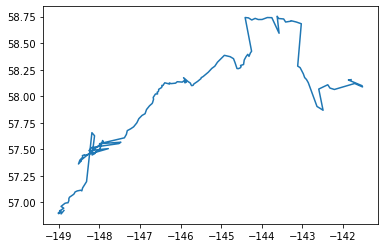

In [12]:
plt.plot(ds_bird.lon[0,:],ds_bird.lat[0,:])

In [17]:
def get_data():
    
    #climatology years
    cyr1,cyr2='1993-01-01','2018-12-31'
    
    # CCMP test
    dir_pattern_zarr = 'F:/data/sat_data/ccmp/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_ccmp = ds.sortby(ds.lon)
    ds_ccmp = ds_ccmp.drop('nobs')
    for var in ds_ccmp:
        tem = ds_ccmp[var].attrs
        tem['var_name']='ccmp_'+str(var)
        ds_ccmp[var].attrs=tem
#    ds_ccmp_clim = ds_ccmp.sel(time=slice(cyr1,cyr2))
#    ds_ccmp_clim = ds_ccmp_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    # AVISO test
    dir_pattern_zarr = 'F:/data/sat_data/aviso/zarr/'
    ds= xr.open_zarr(dir_pattern_zarr)
    ds = ds.rename({'latitude':'lat','longitude':'lon'})
    ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
    ds_aviso = ds.sortby(ds.lon).drop({'lat_bnds','lon_bnds','crs','err'})
    for var in ds_aviso:
        tem = ds_aviso[var].attrs
        tem['var_name']='aviso_'+str(var)
        ds_aviso[var].attrs=tem
#    ds_aviso_clim = ds_aviso.sel(time=slice(cyr1,cyr2))
#    ds_aviso_clim = ds_aviso_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)    

    #sst
    dir_pattern_zarr = 'F:/data/sat_data/sst/cmc/zarr/'
    ds_sst= xr.open_zarr(dir_pattern_zarr)
    ds_sst = ds_sst.drop({'analysis_error','mask','sea_ice_fraction'})
    tem = ds_sst.analysed_sst.attrs
    tem['var_name']='cmc_sst'
    ds_sst.analysed_sst.attrs=tem
#    ds_sst_clim = ds_sst.sel(time=slice(cyr1,cyr2))
#    ds_sst_clim = ds_sst_clim.groupby('time.dayofyear').mean('time',keep_attrs=True,skipna=False)
    
    #get bathymetry from ETOPO1
    fname_topo = 'F:/data/topo/ETOPO1_Ice_g_gmt4.grd'
    ds = xr.open_dataset(fname_topo)
    ds_topo = ds.rename_dims({'x':'lon','y':'lat'}).rename({'x':'lon','y':'lat'})
    tem = ds_topo.z.attrs
    tem['var_name']='etopo_depth'
    ds_topo.z.attrs=tem
    
    ds_color = xr.open_dataset('https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v4.2-DAILY')
    for var in ds_color:
        if not var=='chlor_a':
            ds_color = ds_color.drop(var)

    #put data into a dictionary
    data_dict={'aviso':ds_aviso,
               'wnd':ds_ccmp,
               'sst':ds_sst,
               'color':ds_color,
              'topo':ds_topo}
#    clim_dict={'aviso_clim':ds_aviso_clim,
#               'wnd_clim':ds_ccmp_clim,
#               'sst_clim':ds_sst_clim}
  
    return data_dict#,clim_dict

data = get_data()
#data,clim = get_data()

In [19]:
for name in data:
    ilen_bird1 = len(ds_bird.track)
    ilen_bird2 = len(ds_bird.observation_number)
    for name in data:
        ds_data=data[name]
        if name=='topo':
            continue
        if not name==input_data:
            continue
        print('name',name)   
        for var in ds_data:
            var_tem=ds_data[var].attrs['var_name']
            ds_bird[var_tem]=xr.DataArray(np.nan*np.empty((ilen_bird1,ilen_bird2), 
                                                          dtype=str(ds_data[var].dtype)), 
                                          coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                          dims=('track','observation_number'))
            ds_bird[var_tem].attrs=ds_data[var].attrs
        print('var',var_tem)
        for i in range(ilen_bird1):
            for j in range(10):#ilen_bird2):
                if np.isnan(ds_bird.lat[i,j]):
                    continue
                if ds_bird.time[i,j]<ds_data.time.min():
                    continue
                if ds_bird.time[i,j]>ds_data.time.max():
                    continue
                t1,t2 = ds_bird.time[i,j]-np.timedelta64(24,'h'), ds_bird.time[i,j]+np.timedelta64(24,'h')
                lat1,lat2=ds_bird.lat[i,j]-.5,ds_bird.lat[i,j]+.5
                lon1,lon2=ds_bird.lon[i,j]-.5,ds_bird.lon[i,j]+.5
                tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
                tem = tem.interp(time=ds_bird.time[i,j],lat=ds_bird.lat[i,j],lon=ds_bird.lon[i,j])
                for var in ds_data:
                    var_tem=ds_data[var].attrs['var_name']
                    ds_bird[var_tem][i,j]=tem[var].data
            print(i,ilen_bird1)
        #df_bird = ds_bird.to_dataframe()
        ds_bird.to_netcdf(filename_origin_out+name+'.nc')


name wnd
var ccmp_vwnd
0 765
1 765
2 765
3 765
4 765
5 765
6 765
7 765
8 765
9 765
10 765
11 765
12 765
13 765
14 765
15 765
16 765
17 765
18 765
19 765
20 765
21 765
22 765
23 765
24 765
25 765
26 765
27 765
28 765
29 765
30 765
31 765
32 765
33 765
34 765
35 765
36 765
37 765
38 765
39 765
40 765
41 765
42 765
43 765
44 765
45 765
46 765
47 765
48 765
49 765
50 765
51 765
52 765
53 765
54 765
55 765
56 765
57 765
58 765
59 765
60 765
61 765
62 765
63 765
64 765
65 765
66 765
67 765
68 765
69 765
70 765
71 765
72 765
73 765
74 765
75 765
76 765
77 765
78 765
79 765
80 765
81 765
82 765
83 765
84 765
85 765
86 765
87 765
88 765
89 765
90 765
91 765
92 765
93 765
94 765
95 765
96 765
97 765
98 765
99 765
100 765
101 765
102 765
103 765
104 765
105 765
106 765
107 765
108 765
109 765
110 765
111 765
112 765
113 765
114 765
115 765
116 765
117 765
118 765
119 765
120 765
121 765
122 765
123 765
124 765
125 765
126 765
127 765
128 765
129 765
130 765
131 765
132 765
133 765
134 765
135 765

281 765
282 765
283 765
284 765
285 765
286 765
287 765
288 765
289 765
290 765
291 765
292 765
293 765
294 765
295 765
296 765
297 765
298 765
299 765
300 765
301 765
302 765
303 765
304 765
305 765
306 765
307 765
308 765
309 765
310 765
311 765
312 765
313 765
314 765
315 765
316 765
317 765
318 765
319 765
320 765
321 765
322 765
323 765
324 765
325 765
326 765
327 765
328 765
329 765
330 765
331 765
332 765
333 765
334 765
335 765
336 765
337 765
338 765
339 765
340 765
341 765
342 765
343 765
344 765
345 765
346 765
347 765
348 765
349 765
350 765
351 765
352 765
353 765
354 765
355 765
356 765
357 765
358 765
359 765
360 765
361 765
362 765
363 765
364 765
365 765
366 765
367 765
368 765
369 765
370 765
371 765
372 765
373 765
374 765
375 765
376 765
377 765
378 765
379 765
380 765
381 765
382 765
383 765
384 765
385 765
386 765
387 765
388 765
389 765
390 765
391 765
392 765
393 765
394 765
395 765
396 765
397 765
398 765
399 765
400 765
401 765
402 765
403 765
404 765
405 765


551 765
552 765
553 765
554 765
555 765
556 765
557 765
558 765
559 765
560 765
561 765
562 765
563 765
564 765
565 765
566 765
567 765
568 765
569 765
570 765
571 765
572 765
573 765
574 765
575 765
576 765
577 765
578 765
579 765
580 765
581 765
582 765
583 765
584 765
585 765
586 765
587 765
588 765
589 765
590 765
591 765
592 765
593 765
594 765
595 765
596 765
597 765
598 765
599 765
600 765
601 765
602 765
603 765
604 765
605 765
606 765
607 765
608 765
609 765
610 765
611 765
612 765
613 765
614 765
615 765
616 765
617 765
618 765
619 765
620 765
621 765
622 765
623 765
624 765
625 765
626 765
627 765
628 765
629 765
630 765
631 765
632 765
633 765
634 765
635 765
636 765
637 765
638 765
639 765
640 765
641 765
642 765
643 765
644 765
645 765
646 765
647 765
648 765
649 765
650 765
651 765
652 765
653 765
654 765
655 765
656 765
657 765
658 765
659 765
660 765
661 765
662 765
663 765
664 765
665 765
666 765
667 765
668 765
669 765
670 765
671 765
672 765
673 765
674 765
675 765


63 765
64 765
65 765
66 765
67 765
68 765
69 765
70 765
71 765
72 765
73 765
74 765
75 765
76 765
77 765
78 765
79 765
80 765
81 765
82 765
83 765
84 765
85 765
86 765
87 765
88 765
89 765
90 765
91 765
92 765
93 765
94 765
95 765
96 765
97 765
98 765
99 765
100 765
101 765
102 765
103 765
104 765
105 765
106 765
107 765
108 765
109 765
110 765
111 765
112 765
113 765
114 765
115 765
116 765
117 765
118 765
119 765
120 765
121 765
122 765
123 765
124 765
125 765
126 765
127 765
128 765
129 765
130 765
131 765
132 765
133 765
134 765
135 765
136 765
137 765
138 765
139 765
140 765
141 765
142 765
143 765
144 765
145 765
146 765
147 765
148 765
149 765
150 765
151 765
152 765
153 765
154 765
155 765
156 765
157 765
158 765
159 765
160 765
161 765
162 765
163 765
164 765
165 765
166 765
167 765
168 765
169 765
170 765
171 765
172 765
173 765
174 765
175 765
176 765
177 765
178 765
179 765
180 765
181 765
182 765
183 765
184 765
185 765
186 765
187 765
188 765
189 765
190 765
191 765
192 7

NameError: name 'filename_origin_out_' is not defined

In [23]:
ds_bird.to_netcdf(filename_origin_out+'all'+'.nc')


In [15]:
input_data = 'wnd'
ilen_bird1 = len(ds_bird.track)
ilen_bird2 = len(ds_bird.observation_number)
for name in data:
    ds_data=data[name]
    if name=='topo':
        continue
    if not name==input_data:
        continue
    print('name',name)   
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']
        ds_bird[var_tem]=xr.DataArray(np.nan*np.empty((ilen_bird1,ilen_bird2), 
                                                      dtype=str(ds_data[var].dtype)), 
                                      coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                      dims=('track','observation_number'))
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(ilen_bird1):
        for j in range(ilen_bird2):
            if np.isnan(ds_bird.lat[i,j]):
                continue
            if ds_bird.time[i,j]<ds_data.time.min():
                continue
            if ds_bird.time[i,j]>ds_data.time.max():
                continue
            t1,t2 = ds_bird.time[i,j]-np.timedelta64(24,'h'), ds_bird.time[i,j]+np.timedelta64(24,'h')
            lat1,lat2=ds_bird.lat[i,j]-.5,ds_bird.lat[i,j]+.5
            lon1,lon2=ds_bird.lon[i,j]-.5,ds_bird.lon[i,j]+.5
            tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
            tem = tem.interp(time=ds_bird.time[i,j],lat=ds_bird.lat[i,j],lon=ds_bird.lon[i,j])
            for var in ds_data:
                var_tem=ds_data[var].attrs['var_name']
                ds_bird[var_tem][i,j]=tem[var].data
        print(i,ilen_bird1)
    df_bird = ds_bird.to_dataframe()
    ds_bird.to_netcdf(filename_origin_out+name+'.nc')


name wnd
var ccmp_vwnd


KeyboardInterrupt: 

In [12]:
#ds_bird = xr.open_dataset(filename_bird_out_eddy_netcdf)
ilen_bird1 = len(ds_bird.track)
ilen_bird2 = len(ds_bird.observation_number)
for name in data:
    ds_data=data[name]
    if name=='topo':
        continue
#    if not name==input_data:
#        continue
    print('name',name)   
    for var in ds_data:
        var_tem=ds_data[var].attrs['var_name']
        ds_bird[var_tem]=xr.DataArray(np.nan*np.empty((ilen_bird1,ilen_bird2), 
                                                      dtype=str(ds_data[var].dtype)), 
                                      coords={'track': ds_bird.track,'observation_number':ds_bird.observation_number},
                                      dims=('track','observation_number'))
        ds_bird[var_tem].attrs=ds_data[var].attrs
    print('var',var_tem)
    for i in range(5):#ilen_bird1):
        for j in range(ilen_bird2):
            if np.isnan(ds_bird.lat[i,j]):
                continue
            if ds_bird.time[i,j]<ds_data.time.min():
                continue
            if ds_bird.time[i,j]>ds_data.time.max():
                continue
            t1,t2 = ds_bird.time[i,j]-np.timedelta64(24,'h'), ds_bird.time[i,j]+np.timedelta64(24,'h')
            lat1,lat2=ds_bird.lat[i,j]-.5,ds_bird.lat[i,j]+.5
            lon1,lon2=ds_bird.lon[i,j]-.5,ds_bird.lon[i,j]+.5
            tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
            tem = tem.interp(time=ds_bird.time[i,j],lat=ds_bird.lat[i,j],lon=ds_bird.lon[i,j])
            for var in ds_data:
                var_tem=ds_data[var].attrs['var_name']
                ds_bird[var_tem][i,j]=tem[var].data
        print(i)
    #output data
df_bird = ds_bird.to_dataframe()
ds_bird.to_netcdf(filename_origin_out+'test.nc')


name aviso
var aviso_vgosa
0
1
2
3
4
name wnd
var ccmp_vwnd
0
1
2
3
4
name sst
var cmc_sst
0
1
2
3
4


In [9]:
ds_bird.to_netcdf(filename_origin_out+name+'.nc')


In [11]:
#interp will create a new 2D array, to avoid that put the lat/lon into dataarrays
ds_topo=data['topo']
new_lat = xr.DataArray(ds_bird.lat.data, dims='z')
new_lon = xr.DataArray(ds_bird.lon.data, dims='z')
tem = ds_topo.z.interp(lat=new_lat, lon=new_lon,method='nearest')
ds_bird['ETOPO_depth'] = xr.DataArray(tem.data, coords={'track': ds_bird.track,'observation_number':'ds_bird.observation_number'},
                                      dims=('track','observation_number'))
#ds_bird = ds_bird.drop('obs')

ValueError: different number of dimensions on data and dims: 2 vs 1

# collocate color

In [16]:
ds_color = xr.open_dataset('https://rsg.pml.ac.uk/thredds/dodsC/CCI_ALL-v4.2-DAILY')
for var in ds_color:
    if not var=='chlor_a':
        ds_color = ds_color.drop(var)
ds_color

<xarray.Dataset>
Dimensions:  (lat: 4320, lon: 8640, time: 8128)
Coordinates:
  * lat      (lat) float32 89.979164 89.9375 89.895836 ... -89.9375 -89.979164
  * lon      (lon) float32 -179.97917 -179.9375 ... 179.9375 179.97917
  * time     (time) datetime64[ns] 1997-09-04 1997-09-06 ... 2019-12-31
Data variables:
    chlor_a  (time, lat, lon) float32 ...
Attributes:
    Conventions:                    CF-1.7
    start_date:                     30-DEC-2019 00:00:00.000000
    stop_date:                      30-DEC-2019 23:59:00.000000
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date:                  20200121T164055Z
    creator_email:                  help@esa-oceancolour-cci.org
    creator_name:                   Plymouth Marine Laboratory
    creator_url:                    http://esa-oceancolour-cci.org
    date_created:                   20200121T164055Z
    geospatial_lat_max:             90.0
    geospatial_lat_min:             -90.0
    geospatial_lat_resolution:      .04166666666666666666
    geospatial_lat_units:           decimal degrees north
    geospatial_lon_max:             180.0
    geospatial_lon_min:             -180.0
    geospatial_lon_resolution:      .04166666666666666666
    geospatial_lon_units:           decimal degrees east
    geospatial_vertical_max:        0.0
    geospatial_vertical_min:        0.0
    history:                        Source data were: NASA OBPG SeaWiFS level...
    institution:                    Plymouth Marine Laboratory
    keywords:                       satellite,observation,ocean,ocean colour
    keywords_vocabulary:            none
    license:                        ESA CCI Data Policy: free and open access...
    naming_authority:               uk.ac.pml
    number_of_optical_water_types:  14
    platform:                       Orbview-2,Aqua,Envisat,Suomi-NPP
    processing_level:               Level-3
    project:                        Climate Change Initiative - European Spac...
    references:                     http://www.esa-oceancolour-cci.org/
    sensor:                         SeaWiFS,MODIS,MERIS,VIIRS
    sensors_present:                 MODISA VIIRSN
    source:                         NASA SeaWiFS L2 R2018.0 LAC and GAC, MODI...
    spatial_resolution:             4km nominal at equator
    standard_name_vocabulary:       NetCDF Climate and Forecast (CF) Metadata...
    summary:                        Data products generated by the Ocean Colo...
    time_coverage_duration:         P1D
    time_coverage_end:              201912302359Z
    time_coverage_resolution:       P1D
    time_coverage_start:            201912300000Z
    title:                          ESA CCI Ocean Colour Product
    id:                             ESACCI-OC-L3S-OC_PRODUCTS-MERGED-1D_DAILY...
    product_version:                4.2
    tracking_id:                    23dae2e8-04ff-4d5c-b101-abc77fbd9db2
    git_commit_hash:                85e7d70ef28f64e1c0f9b7f8212b97157a4f1278

In [ ]:
ilen_bird = len(ds_bird.lat)
ds_data = ds_color
for var in ds_data:
    var_tem=var
    ds_bird[var_tem]=xr.DataArray(np.nan*np.empty(ilen_bird, dtype=str(ds_data[var].dtype)), coords={'index': ds_bird.index}, dims=('index'))
    ds_bird[var_tem].attrs=ds_data[var].attrs
print('var',var_tem)
for i in range(ilen_bird):
    t1,t2 = ds_bird.time64[i]-np.timedelta64(5,'D'), ds_bird.time64[i]+np.timedelta64(5,'D')
    lat1,lat2=ds_bird.lat[i]+.1,ds_bird.lat[i]-.1
    lon1,lon2=ds_bird.lon[i]-.1,ds_bird.lon[i]+.1
    tem = ds_data.sel(time=slice(t1,t2),lat=slice(lat1,lat2),lon=slice(lon1,lon2)).load()
    if len(tem)<1:
        continue
    tem = tem.mean(keep_attrs=True)
    for var in ds_data:
        var_tem=var
        ds_bird[var_tem][i]=tem[var].data
    if int(i/100)*100==i:
        print(i,len(ds_bird.lat))

In [ ]:
#output data
df_bird = ds_bird.to_dataframe()
df_bird.to_csv(filename_bird_out+input_data+'.csv')
ds_bird.to_netcdf(filename_bird_out_netcdf+input_data+'.nc')

